In [22]:
import importlib
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
import lib.utils_RSA as rsa

importlib.reload(rsa)


<module 'lib.utils_RSA' from '/home/alban/SAYCam_Vs_EGO4D/lib/utils_RSA.py'>

The 3 images shown - are their resulting activations?


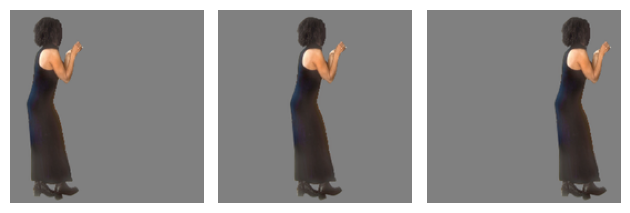

['stimulus7_left.tif', 'stimulus7.tif', 'stimulus7_right.tif']

In [23]:
# First do some analysis on the translation test - see if my understanding of representations are right

path2activations = '/data/alban/activations/saycam_hmIT_Translationtest'
#path2dataset = 'testsets/hmIT_Translationtest'
path2dataset = 'testsets/hmIT_Translationtest'

listimages = os.listdir(path2dataset)
fig, subs = plt.subplots(1,3)
for i, img in enumerate(listimages):
    img = cv2.imread(join(path2dataset, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    subs[i].imshow(img)
    subs[i].axis('off')
print('The 3 images shown - are their resulting activations?')
fig.tight_layout()
plt.show()

listimages

In [24]:
cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
patch_token.shape

(3, 7680000)

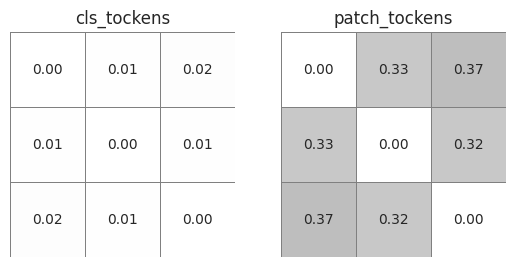

In [25]:
### Correlations
corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1- corr_cls,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1- corr_patch,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()



In [26]:
## Dot product
dot_cls = rsa.similarity_dotproduct(cls_token)
dot_patch = rsa.similarity_dotproduct(patch_token)


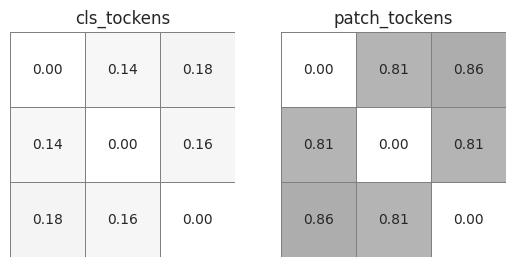

In [27]:

l2_cls = rsa.similarity_L2norm(cls_token)
l2_patch = rsa.similarity_L2norm(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(l2_cls,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

sns.heatmap(l2_patch,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()


As we did expect, we have low dissimilarity scores when using the cls_tokens as representations, and mid when suing the patch tokens. This suggests that the cls tokens are largely agnostic of spatial properties, and thus more appropriate to compare how semantic information is being represented.

Let's do the same with the actual 92 images.

In [28]:
# Get image paths and the dataset's metadata
from natsort import natsorted
import pandas as pd

df = pd.read_excel('testsets/metadata_hmIT/mapping.xlsx')
print(df)


       class1      class2  class3     image  informed_exclude
0     animate       human    body  0001.jpg                 0
1     animate       human    body  0002.jpg                 0
2     animate       human    body  0003.jpg                 0
3     animate       human    body  0004.jpg                 0
4     animate       human    body  0005.jpg                 0
..        ...         ...     ...       ...               ...
87  inanimate  artificial  object  0088.jpg                 0
88  inanimate  artificial  object  0089.jpg                 0
89  inanimate  artificial  object  0090.jpg                 1
90  inanimate  artificial  object  0091.jpg                 0
91  inanimate  artificial  object  0092.jpg                 0

[92 rows x 5 columns]


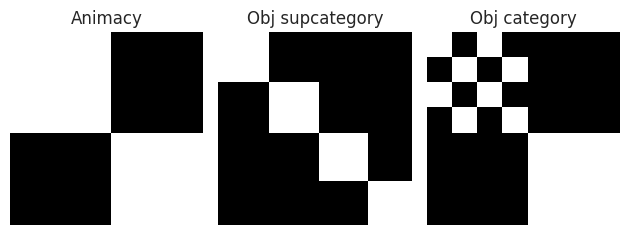

In [29]:
# Create similarity matrices for animacy
animate = df['class1'] == 'animate'
inanimate = df['class1'] == 'inanimate'
corr_animacy = np.corrcoef(np.stack([animate,inanimate], axis =1))

# Create similarity matrices for all object supcategories
human = df['class2'] == 'human'
animal = df['class2'] == 'animal'
natural = df['class2'] == 'natural'
artificial = df['class2'] == 'artificial'
corr_supobj = np.corrcoef(np.stack([human,animal, natural, artificial], axis =1))

#create similarity matrice for object categories
labels = df['class3'].unique()
vecs = list()
for label in labels:
    vecs.append(df['class3'] == label)
corr_obj = np.corrcoef(np.stack(vecs, axis =1))

fig, subs = plt.subplots(1,3)
sns.heatmap(1-corr_animacy,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_supobj,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,

            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_obj,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[2],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale


subs[0].set_title('Animacy')
subs[1].set_title('Obj supcategory')
subs[2].set_title('Obj category')

subs[0].axis('off')
subs[1].axis('off')
subs[2].axis('off')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_classes.png', dpi=300, bbox_inches='tight')


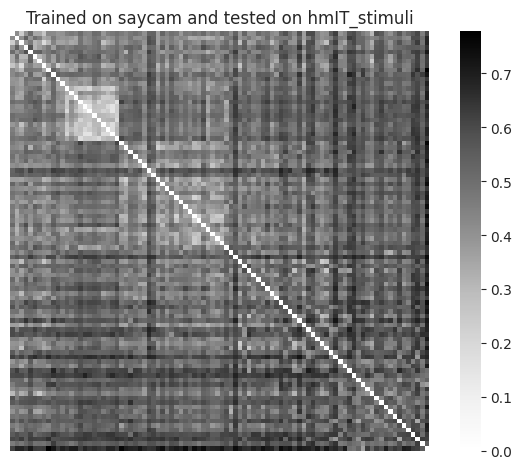

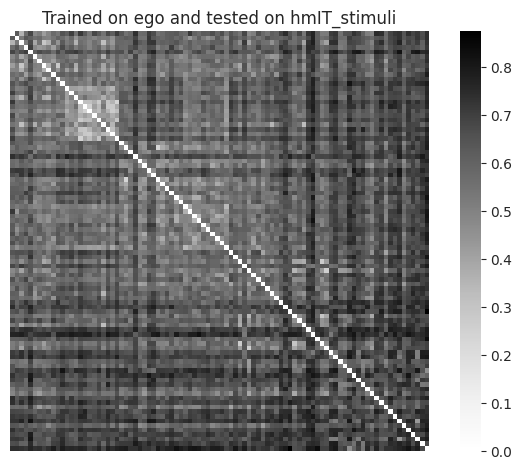

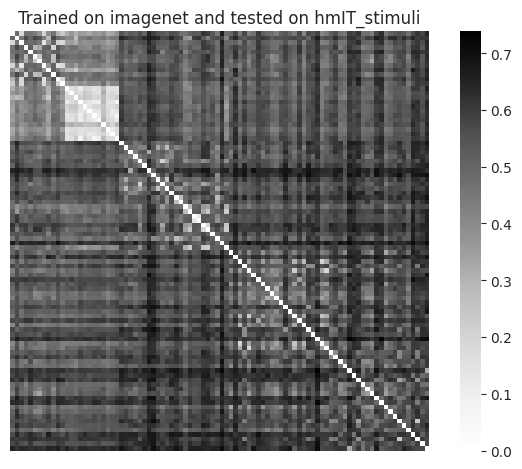

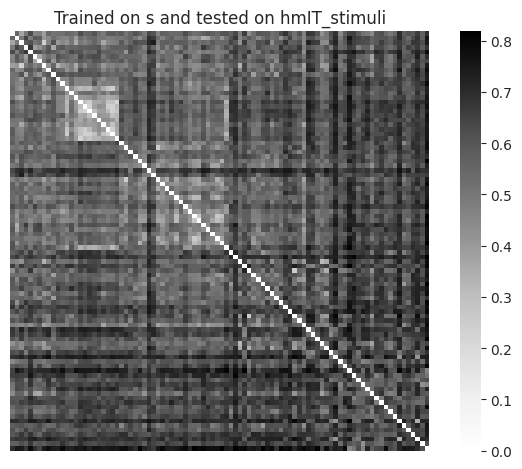

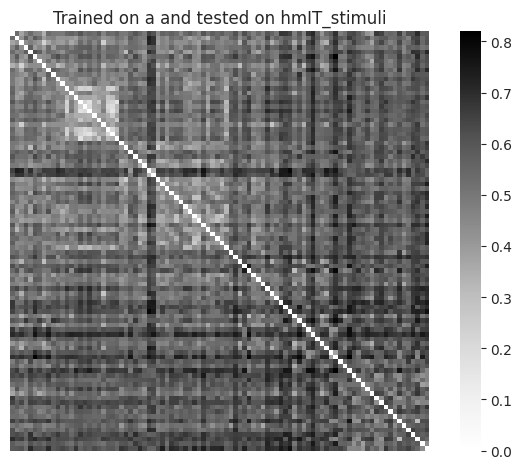

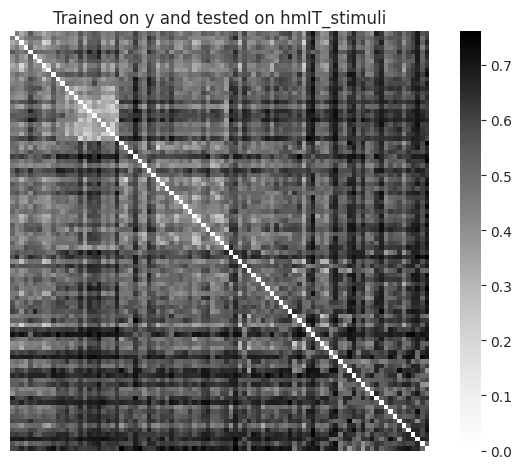

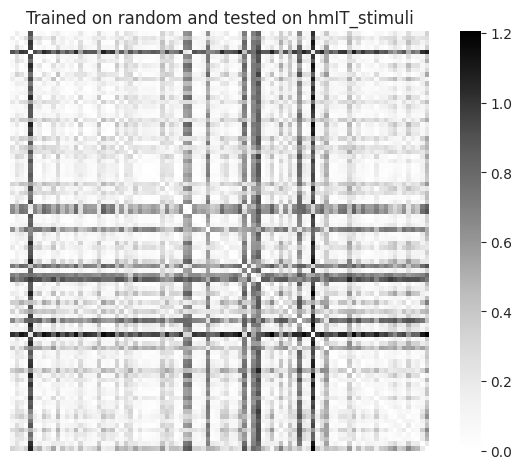

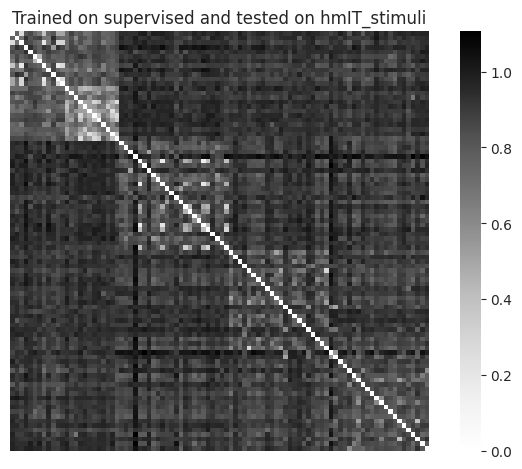

In [35]:
importlib.reload(rsa)
dataset = 'hmIT_stimuli' # alternatively 100_faces or hm_IT_stimuli
path2dataset = f'testsets/{dataset}'

models = ['saycam', 'ego', 'imagenet', 's', 'a', 'y', 'random', 'supervised']

listimages = os.listdir(path2dataset)
listimages = natsorted(listimages) # for hm_IT dataset or
#print(listimages)

RDMs = {}
for i, model in enumerate(models):
    RDMs[model] = rsa.compute_RDMs(model, dataset, listimages)



In [31]:
SIMs = rsa.corrs_layers(RDMs, models)

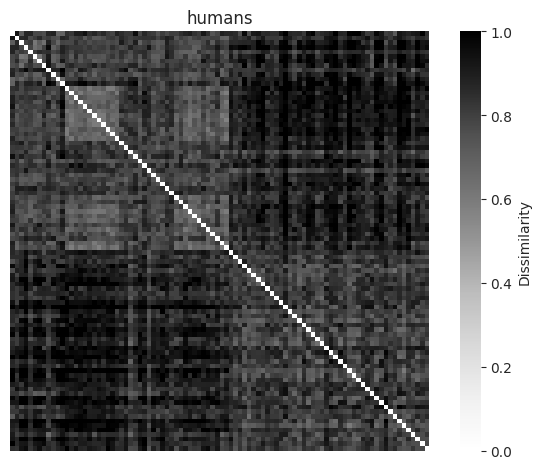

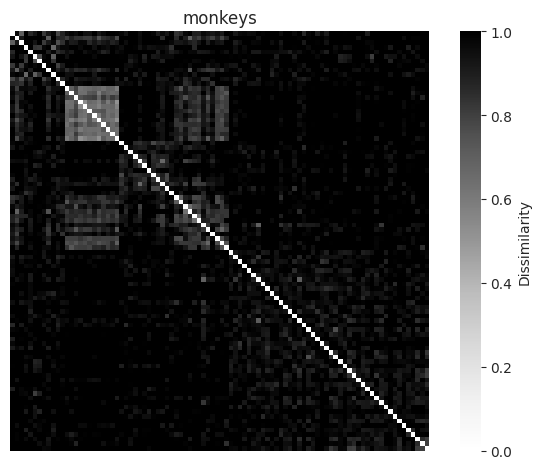

In [32]:

### for comparison, load the RDMs from humans and monkeys
RDM_humans = np.loadtxt('testsets/metadata_hmIT/RDM_hIT_fig1.txt')
RDM_monkeys = np.loadtxt('testsets/metadata_hmIT/RDM_mIT_fig1.txt')

rsa.display_RDM(RDM_humans, 'humans')
rsa.display_RDM(RDM_monkeys, 'monkeys')

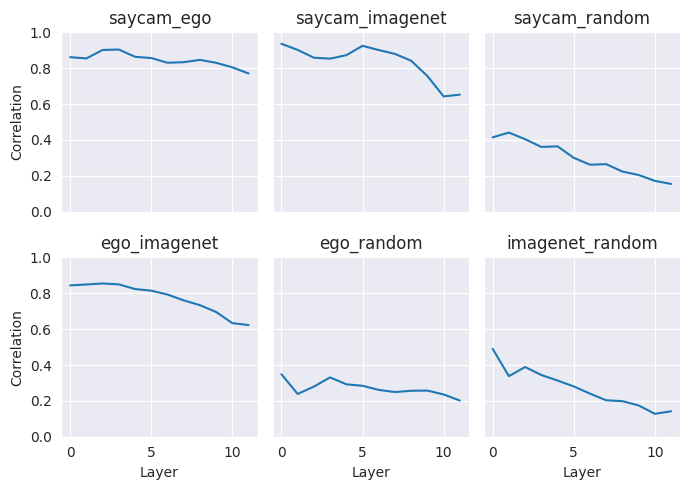

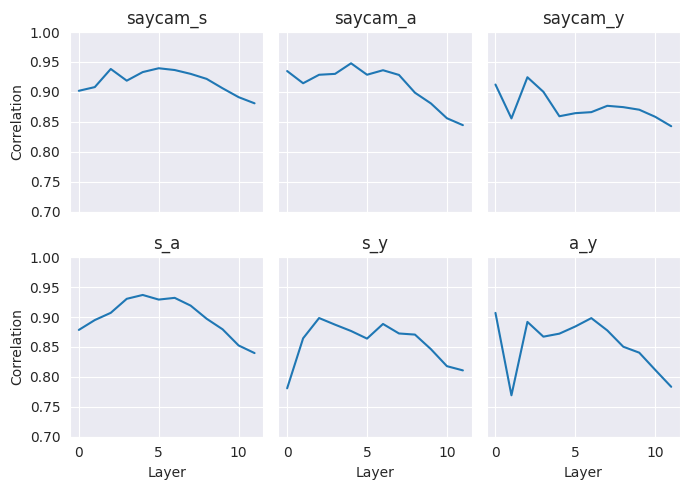

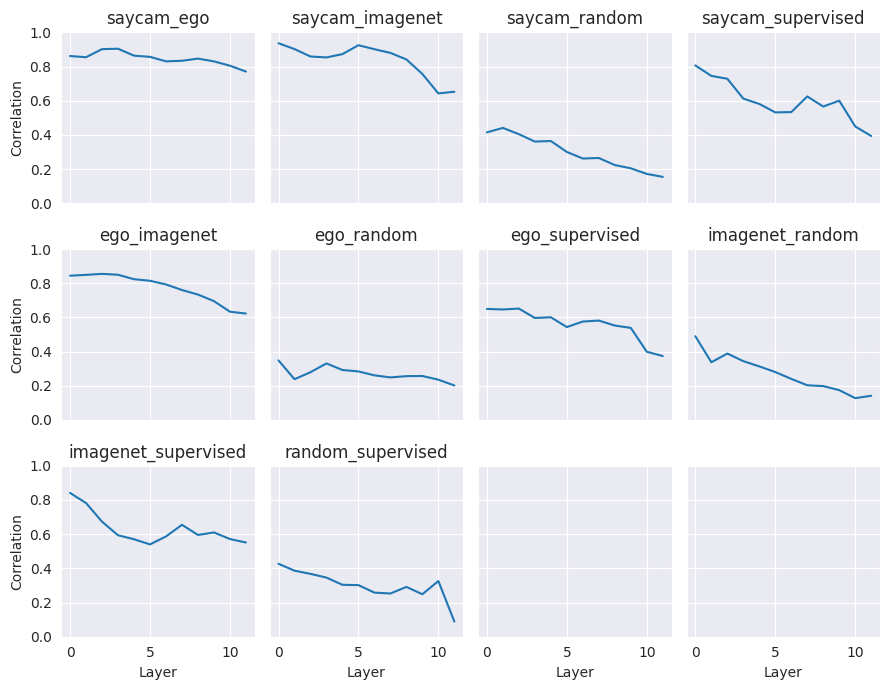

In [33]:
rsa.plot_similarities(SIMs, ['saycam', 'ego', 'imagenet', 'random'])
rsa.plot_similarities(SIMs, ['saycam', 's', 'a', 'y'])
rsa.plot_similarities(SIMs, ['saycam', 'ego', 'imagenet', 'random', 'supervised'])

Running t-SNE on dissimilarity matrix...


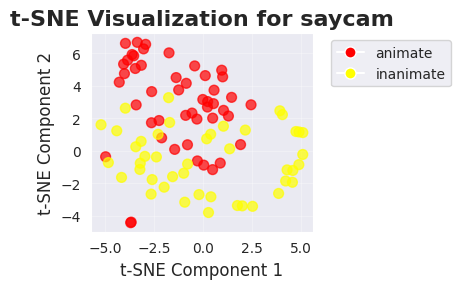

Silhouette Score: 0.193
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


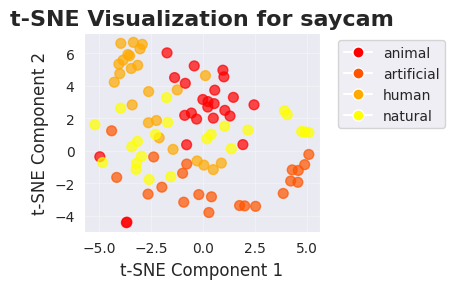

Silhouette Score: 0.101
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


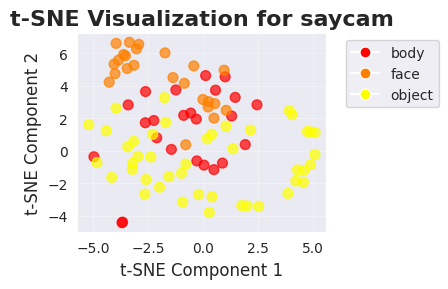

Silhouette Score: 0.064
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images
Running t-SNE on dissimilarity matrix...


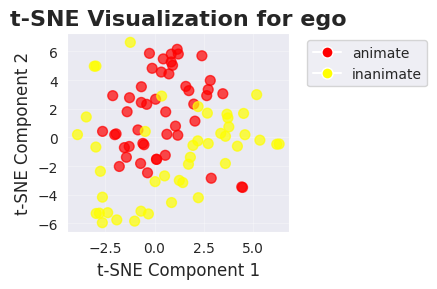

Silhouette Score: 0.133
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


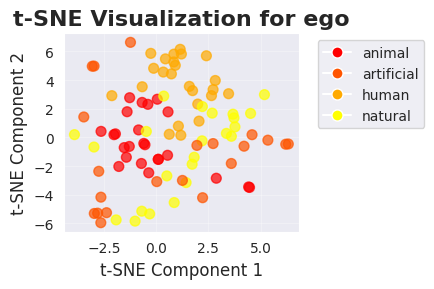

Silhouette Score: 0.065
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


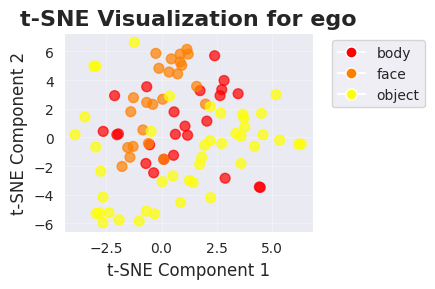

Silhouette Score: -0.009
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images
Running t-SNE on dissimilarity matrix...


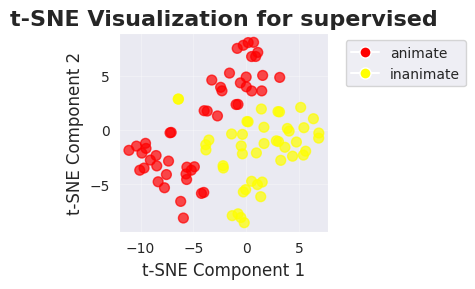

Silhouette Score: 0.250
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


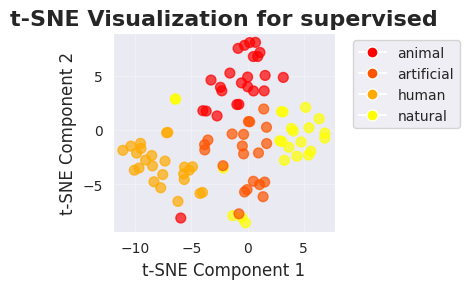

Silhouette Score: 0.325
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


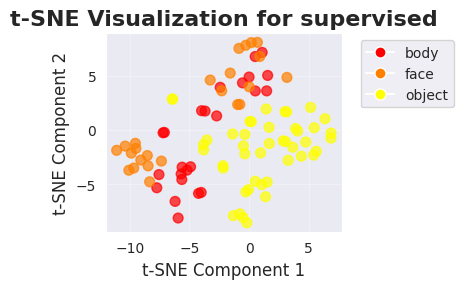

Silhouette Score: 0.154
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images


In [34]:
### Work towards t-sne visualization

# Main execution

labels1 = df['class1'] # Animacy
labels2 = df['class2'] # Animacy
labels3 = df['class3'] # Animacy

# For demonstration, run with synthetic data
title="t-SNE Visualization for saycam"
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['saycam'][-1], labels1, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['saycam'][-1], labels2, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['saycam'][-1], labels3, title)

title="t-SNE Visualization for ego"
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['ego'][-1], labels1, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['ego'][-1], labels2, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['ego'][-1], labels3, title)

title="t-SNE Visualization for supervised"
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['supervised'][-1], labels1, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['supervised'][-1], labels2, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['supervised'][-1], labels3, title)

# 2. Save results
results_df = pd.DataFrame({
    'tsne_x': tsne_results[:, 0],
    'tsne_y': tsne_results[:, 1],
    'label': labels,
    'image_id': range(len(labels))
})


In [47]:
#### MDS and Procrustes
import lib.algos as algos
from scipy.spatial import procrustes

RESULTlayersaycam, stress_layersaycam = algos.MDS(RDMs['saycam'][-1])
RESULTlayerego, stress_layerego = algos.MDS(RDMs['ego'][-1])

### amount of variance explained by the first 5 layers
print(np.sum((stress_layer/np.sum(stress_layer[stress_layer>0]))[0:5]))

#RESULTlayersaycam.shape
#RESULTlayerego.shape
procrustes(RESULTlayersaycam[:,:10], RESULTlayerego[:,:10])

0.41631927042018985


(array([[ 9.96022978e-03, -6.02709021e-03,  5.56645478e-02,
         -3.72577354e-02,  4.43384691e-03, -1.80249116e-02,
          2.09036450e-02, -7.04551297e-03,  1.13733985e-02,
         -2.44260032e-02],
        [ 2.45808864e-02,  2.84303092e-03, -2.97740993e-02,
          9.59081112e-03,  3.74442961e-02,  5.15132629e-03,
         -3.83225405e-03, -3.47963083e-02,  1.55313204e-02,
          1.71133958e-02],
        [ 4.12344493e-02, -7.54150933e-03,  4.88026282e-02,
         -4.06705953e-02,  3.11324915e-02,  4.79140171e-03,
          1.20701836e-02, -8.80095015e-04,  1.00264147e-02,
          3.19505900e-03],
        [-2.71592343e-02,  1.07901504e-02,  4.15083693e-02,
         -6.33772755e-02, -1.80622550e-02, -3.20114260e-02,
         -2.49690189e-02,  2.66727986e-02, -3.58824185e-02,
         -2.42692939e-02],
        [ 3.43458821e-02, -8.44075495e-03, -5.05126940e-02,
          2.13786077e-02, -1.62352815e-02, -1.77728934e-02,
          1.50570567e-02, -4.47806095e-02,  2.728362